In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as ltb
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Integer

In [3]:
#pip install numpy==1.19.5

In [4]:
# Importing unnormalized data from pre-processing
X_test = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/X_test_asthma")
X_train = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/X_train_asthma")
y_test = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/y_test_asthma")
y_train = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/y_train_asthma")

In [5]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(54242, 12) (54242, 2) (18081, 12) (18081, 2)


In [6]:
y_train.head()

,CensusTract,Asthma_prevalence
0,37159051001,9.3
1,34003046300,8.6
2,12111381804,9.2
3,29133950400,11.7
4,36043010400,10.9


In [7]:
X_train.head()

,CensusTract,PM25,OZONE,DSLPM,CANCER,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF,PWDIS
0,37159051001,8.406496,45.409764,0.259756,34.666424,0.462520,108.690218,0.229364,0.066483,0.071494,0.114913,0.000000
1,34003046300,8.539930,40.596072,1.042458,39.917145,0.581106,1297.765730,0.718710,0.257747,1.940537,10.082969,0.099259
2,12111381804,7.526365,29.702844,0.412573,25.902847,0.364634,70.883246,0.000000,0.060492,0.528740,0.090997,0.000000
3,29133950400,9.157663,45.454297,0.281388,29.276592,0.412888,0.000000,0.317822,0.038818,0.324983,0.062920,0.000088
4,36043010400,6.136506,36.183244,0.205306,19.351880,0.230780,503.789166,0.760216,0.025240,0.594394,2.071769,0.012973


In [8]:
# Re-indexing
X_test.set_index("CensusTract", inplace=True)
X_train.set_index("CensusTract", inplace=True)
y_test.drop("CensusTract", axis=1, inplace=True)
y_train.drop("CensusTract", axis=1, inplace=True)

In [9]:
# Getting the y-data into correct shape for model
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(54242, 11) (54242,) (18081, 11) (18081,)


In [10]:
X_train.head()

,PM25,OZONE,DSLPM,CANCER,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF,PWDIS
CensusTract,,,,,,,,,,,
37159051001,8.406496,45.409764,0.259756,34.666424,0.462520,108.690218,0.229364,0.066483,0.071494,0.114913,0.000000
34003046300,8.539930,40.596072,1.042458,39.917145,0.581106,1297.765730,0.718710,0.257747,1.940537,10.082969,0.099259
12111381804,7.526365,29.702844,0.412573,25.902847,0.364634,70.883246,0.000000,0.060492,0.528740,0.090997,0.000000
29133950400,9.157663,45.454297,0.281388,29.276592,0.412888,0.000000,0.317822,0.038818,0.324983,0.062920,0.000088
36043010400,6.136506,36.183244,0.205306,19.351880,0.230780,503.789166,0.760216,0.025240,0.594394,2.071769,0.012973


### Multiple OLS in the EDA notebook found no reasonable correlation. 

In [27]:
# Instantiating RandomForestRegressor with default hyperparameters
rf = RandomForestRegressor() 
rf.fit(X_train, y_train)

RandomForestRegressor()

In [28]:
y_pred = rf.predict(X_test)

In [29]:
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.5541049885421765
MAE: 0.7563526906697638
MSE: 1.0799217303799569
RMSE: 1.0391928263705235


### This R<sup>2</sup> value indicates that this model is mediocre.

In [45]:
import pickle

pickle.dump(rf, open('/Users/butler/Documents/hp/Capstone_Two/models/asthma_best_model_rf_default.pkl', 'wb'))

In [30]:
# Instantiating RandomForestRegressor and using RandomizedSearch to get best values for n_estimators and max_depth
rf = RandomForestRegressor() 
params = {"n_estimators":range(1,500), "max_depth":range(1,30)}

rs = RandomizedSearchCV(rf, params)

In [31]:
rs.fit(X_train, y_train)   

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': range(1, 30),
                                        'n_estimators': range(1, 500)})

In [32]:
rs.best_estimator_

RandomForestRegressor(max_depth=25, n_estimators=466)

In [33]:
y_pred = rs.predict(X_test)

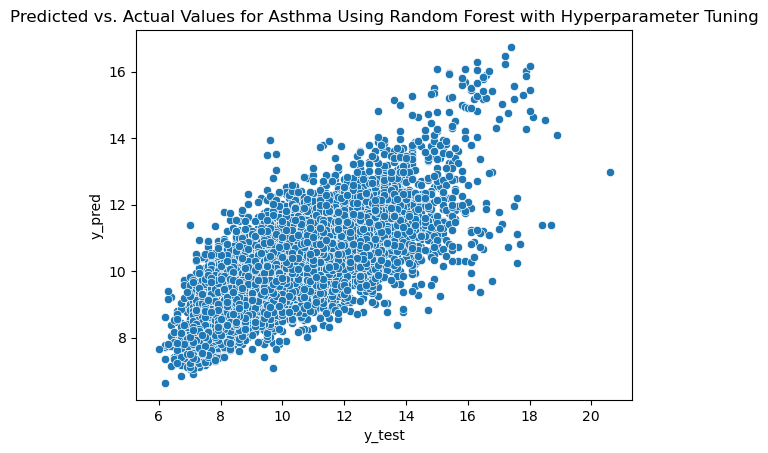

In [34]:
ax = sns.scatterplot(x=y_test, y=y_pred)
_ = ax.set_title("Predicted vs. Actual Values for Asthma Using Random Forest with Hyperparameter Tuning")
_ = ax.set_xlabel("y_test")
_ = ax.set_ylabel("y_pred")

In [35]:
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.55072325094747
MAE: 0.7592828983919162
MSE 1.0881120259004795
RMSE: 1.0431260834148859


In [ ]:
import pickle

pickle.dump(rs, open('/Users/butler/Documents/hp/Capstone_Two/models/asthma_best_model_rf_randomized.pkl', 'wb'))

### The hyperparameter tuning did not make much different in the R<sup>2</sup> value.

In [26]:
# Instantiating AdaBoostRegressor with default hyperparameters
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

AdaBoostRegressor()

In [27]:
y_pred = ada.predict(X_test)

In [28]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: -0.10792973351486457
MAE: 1.349226856349173
MSE: 2.6540161522417147
RMSE: 1.6291151439483076


### Adaboost with the default hyperparameters does not give reasonable results.

In [29]:
# Instantiating AdaBoost Regressor and using RandomizedSearch to get best values for best n_estimators and learning rate
ada = AdaBoostRegressor()
params = {"n_estimators":range(1,500), "learning_rate":np.arange(1e-3,100)}

rs = RandomizedSearchCV(ada, params)

In [30]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=AdaBoostRegressor(),
                   param_distributions={'learning_rate': array([1.0000e-03, 1.0010e+00, 2.0010e+00, 3.0010e+00, 4.0010e+00,
       5.0010e+00, 6.0010e+00, 7.0010e+00, 8.0010e+00, 9.0010e+00,
       1.0001e+01, 1.1001e+01, 1.2001e+01, 1.3001e+01, 1.4001e+01,
       1.5001e+01, 1.6001e+01, 1.7001e+01, 1.8001e+01, 1.9001e+01,
       2.0001e+01, 2.1001e+01, 2.2001e+01, 2.30...
       7.0001e+01, 7.1001e+01, 7.2001e+01, 7.3001e+01, 7.4001e+01,
       7.5001e+01, 7.6001e+01, 7.7001e+01, 7.8001e+01, 7.9001e+01,
       8.0001e+01, 8.1001e+01, 8.2001e+01, 8.3001e+01, 8.4001e+01,
       8.5001e+01, 8.6001e+01, 8.7001e+01, 8.8001e+01, 8.9001e+01,
       9.0001e+01, 9.1001e+01, 9.2001e+01, 9.3001e+01, 9.4001e+01,
       9.5001e+01, 9.6001e+01, 9.7001e+01, 9.8001e+01, 9.9001e+01]),
                                        'n_estimators': range(1, 500)})

In [31]:
rs.best_estimator_

AdaBoostRegressor(learning_rate=90.00099999999999, n_estimators=483)

In [32]:
y_pred = rs.predict(X_test)

In [33]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: -8.182998605982734
MAE: 4.427432111055448
MSE: 21.997628449750728
RMSE: 4.690162944904018


### The hyperparameter tuning just made this model worse.

### GradientBoost Regressor

In [34]:
# Instantiating GradientBoostRegressor with default parameters
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [35]:
y_pred = gb.predict(X_test)

In [36]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.28534382403561487
MAE: 0.9824301377974484
MSE: 1.711939825183262
RMSE: 1.3084111835288104


### This R<sup>2</sup> is not as good as Random Forest. 

### Now with hyperparameters tuned via randomized search.

In [37]:
# Instantiating GradientBoostingRegressor and using RandomizedSearch to get best values for n_estimators, max_leaf_nodes, and learning rate
gb = GradientBoostingRegressor()
params = {"n_estimators":range(1,500), "max_leaf_nodes":range(2,100), "learning_rate":np.arange(0.01, 1)}

rs = RandomizedSearchCV(gb, params)

In [38]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': array([0.01]),
                                        'max_leaf_nodes': range(2, 100),
                                        'n_estimators': range(1, 500)})

In [39]:
rs.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_leaf_nodes=78,
                          n_estimators=472)

In [40]:
y_pred = rs.predict(X_test)

In [41]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.2422946838330795
MAE: 1.0146846522715876
MSE: 1.8150628933540056
RMSE: 1.347242700241499


### The R<sup>2</sup> value is worse than with the default parameters

### XGBoost Regressor

In [36]:
# Instantiating XGBRegressor with default parameters
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
y_pred = xgb.predict(X_test)

In [38]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.4823812419789373
MAE: 0.8264851463427157
MSE: 1.2536308558637104
RMSE: 1.1196565794312605


### The R<sup>2</sup> is not as good as Random Forest.

### Now with hyperparameters tuned via randomized search.

In [40]:
# Instantiating XGBRegressor and using RandomizedSearch to get best values for max_depth, min_child_weight, and gamma
xgb = XGBRegressor()
params = {"max_depth":range(1,200), "min_child_weight":range(1,200), "gamma":range(1,200)}

rs = RandomizedSearchCV(xgb, params)

In [41]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...ne,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'gamma': range(1, 200),
                                        'max_depth': range(1, 200),
                                        'min_child_weight': range(1, 200)})

In [42]:
rs.best_params_

{'min_child_weight': 145, 'max_depth': 175, 'gamma': 24}

In [43]:
y_pred = rs.predict(X_test)

In [44]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.5028080741259636
MAE: 0.8081327539676784
MSE: 1.2041587170158774
RMSE: 1.0973416592000311


In [39]:
import pickle

pickle.dump(rs, open('/Users/butler/Documents/hp/Capstone_Two/models/COPD_best_model_xgb_randomized.pkl', 'wb'))

### This is better than XGBoost without tuning the hyperparameters and slighting better than Random Forest. 

### Now tuning hyperparameters via Bayesian search

In [11]:
# Trying Bayesian search for XGBoost hyperparameters
opt = BayesSearchCV(XGBRegressor(), {"max_depth":Integer(1,200), "min_child_weight":Integer(1,200), "gamma":Integer(1,200)}, n_iter=32, random_state=0)
_ = opt.fit(X_train, y_train)

In [12]:
opt.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=199, max_leaves=None,
             min_child_weight=81, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [13]:
y_pred = opt.predict(X_test)

In [14]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.5636956107540493
MAE: 0.7543235350575543
MSE: 1.0566940174243797
RMSE: 1.0279562332241483


In [ ]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.4823812419789373
MAE: 0.8264851463427157
MSE: 1.2536308558637104
RMSE: 1.1196565794312605


### The R<sup>2</sup> is not as good as Random Forest.

### Now with hyperparameters tuned via randomized search.

In [ ]:
# Instantiating XGBRegressor and using RandomizedSearch to get best values for max_depth, min_child_weight, and gamma
xgb = XGBRegressor()
params = {"max_depth":range(1,200), "min_child_weight":range(1,200), "gamma":range(1,200)}

rs = RandomizedSearchCV(xgb, params)

In [ ]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...ne,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'gamma': range(1, 200),
                                        'max_depth': range(1, 200),
                                        'min_child_weight': range(1, 200)})

In [ ]:
rs.best_params_

{'min_child_weight': 145, 'max_depth': 175, 'gamma': 24}

In [ ]:
y_pred = rs.predict(X_test)

In [ ]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.5028080741259636
MAE: 0.8081327539676784
MSE: 1.2041587170158774
RMSE: 1.0973416592000311


In [ ]:
import pickle

pickle.dump(rs, open('/Users/butler/Documents/hp/Capstone_Two/models/COPD_best_model_xgb_randomized.pkl', 'wb'))

### This is better than XGBoost without tuning the hyperparameters and slighting better than Random Forest. 

### Now tuning hyperparameters via Bayesian search

In [ ]:
# Trying Bayesian search for XGBoost hyperparameters
opt = BayesSearchCV(XGBRegressor(), {"max_depth":Integer(1,200), "min_child_weight":Integer(1,200), "gamma":Integer(1,200)}, n_iter=32, random_state=0)
_ = opt.fit(X_train, y_train)

In [16]:

xgb = XGBRegressor(min_child_weight=81, max_depth=199, gamma=1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.5636956107540493
MAE: 0.7543235350575543
MSE: 1.0566940174243797
RMSE: 1.0279562332241483


In [17]:
import pickle

pickle.dump(opt, open('/Users/butler/Documents/hp/Capstone_Two/models/asthma_best_model_xgb.pkl', 'wb'))

### This is slightly better than XGBoost with hyperparameters determined by RandomizedSearchCV and the best model so far.

In [54]:
# Instantiating LGBMRegressor and using RandomizedSearch to determine the best values for reg_alpha and reg_lambda
lgbm = ltb.LGBMRegressor()
params = {"reg_alpha":np.arange(1e-3,100), "reg_lambda":np.arange(1e-3,100)}

rs = RandomizedSearchCV(lgbm, params)

In [55]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=LGBMRegressor(),
                   param_distributions={'reg_alpha': array([1.0000e-03, 1.0010e+00, 2.0010e+00, 3.0010e+00, 4.0010e+00,
       5.0010e+00, 6.0010e+00, 7.0010e+00, 8.0010e+00, 9.0010e+00,
       1.0001e+01, 1.1001e+01, 1.2001e+01, 1.3001e+01, 1.4001e+01,
       1.5001e+01, 1.6001e+01, 1.7001e+01, 1.8001e+01, 1.9001e+01,
       2.0001e+01, 2.1001e+01, 2.2001e+01, 2.3001e+01, 2...
       6.5001e+01, 6.6001e+01, 6.7001e+01, 6.8001e+01, 6.9001e+01,
       7.0001e+01, 7.1001e+01, 7.2001e+01, 7.3001e+01, 7.4001e+01,
       7.5001e+01, 7.6001e+01, 7.7001e+01, 7.8001e+01, 7.9001e+01,
       8.0001e+01, 8.1001e+01, 8.2001e+01, 8.3001e+01, 8.4001e+01,
       8.5001e+01, 8.6001e+01, 8.7001e+01, 8.8001e+01, 8.9001e+01,
       9.0001e+01, 9.1001e+01, 9.2001e+01, 9.3001e+01, 9.4001e+01,
       9.5001e+01, 9.6001e+01, 9.7001e+01, 9.8001e+01, 9.9001e+01])})

In [56]:
rs.best_estimator_

LGBMRegressor(reg_alpha=38.00099999999999, reg_lambda=6.0009999999999994)

In [57]:
y_pred = rs.predict(X_test)

In [58]:
print("R2 score:", r2_score(y_test, y_pred)  )
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.42957166443229655
MAE: 0.8729649253870334
MSE: 1.3664458769331607
RMSE: 1.1689507589856643


### Not as good as XGBoost. 

### Support vector machine requires normalized data.

In [9]:
# Importing data normalized by power transformer from pre-processing
X_test_log = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/X_test_log_asthma")
X_train_log = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/X_train_log_asthma")
X_train_log.head()

,CensusTract,PM25,OZONE,DSLPM,CANCER,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF
0,34013012900,8.879033,39.584332,1.260322,0.433064,0.431948,2.216099,1.587949,1.555297,-0.140360,1.142263
1,18141011304,8.134942,46.296570,-0.460763,-0.921526,-1.078012,-1.097525,-1.124145,1.254736,-0.230320,-0.649248
2,6065030101,12.288512,71.033875,1.427533,0.941976,1.258328,2.133543,0.947802,2.091041,1.797981,1.373394
3,45041002600,8.340545,39.131956,-0.887090,0.425058,0.582148,-1.092730,-0.030026,-1.114267,-1.085755,-1.225681
4,53005010100,11.616038,47.398344,-0.757718,-0.315428,-0.117025,0.040197,0.307845,0.961158,1.781335,0.601703


In [10]:
# Getting rid of extra column
X_train_log.set_index("CensusTract", inplace=True)

In [11]:
X_train_log.head()

,PM25,OZONE,DSLPM,CANCER,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF
CensusTract,,,,,,,,,,
34013012900,8.879033,39.584332,1.260322,0.433064,0.431948,2.216099,1.587949,1.555297,-0.140360,1.142263
18141011304,8.134942,46.296570,-0.460763,-0.921526,-1.078012,-1.097525,-1.124145,1.254736,-0.230320,-0.649248
6065030101,12.288512,71.033875,1.427533,0.941976,1.258328,2.133543,0.947802,2.091041,1.797981,1.373394
45041002600,8.340545,39.131956,-0.887090,0.425058,0.582148,-1.092730,-0.030026,-1.114267,-1.085755,-1.225681
53005010100,11.616038,47.398344,-0.757718,-0.315428,-0.117025,0.040197,0.307845,0.961158,1.781335,0.601703


In [12]:
X_test_log.head()

,CensusTract,PM25,OZONE,DSLPM,CANCER,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF
0,1101005503,9.812856,37.264403,-0.047354,1.760736,2.209913,-0.519460,-1.386465,-0.404069,-1.218927,-0.868389
1,48113018137,9.469961,43.876014,0.522266,0.308777,0.220712,1.350461,-1.374606,-0.645920,-0.771459,-0.980019
2,34013007700,8.919865,39.510561,1.648228,0.716897,1.115787,0.542204,1.409285,2.166501,1.937924,1.717902
3,26125184300,9.458097,43.649177,1.244834,0.050094,-0.121698,1.628998,1.650805,-0.302157,0.576310,0.572255
4,44001030100,6.316000,41.146886,-0.176631,-0.910587,-1.046015,-0.563792,1.180407,-0.250928,-0.769400,-0.663058


In [13]:
# Getting rid of extra column
X_test_log  = X_test_log.set_index("CensusTract")
X_test_log.head()

,PM25,OZONE,DSLPM,CANCER,RESP,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF
CensusTract,,,,,,,,,,
1101005503,9.812856,37.264403,-0.047354,1.760736,2.209913,-0.519460,-1.386465,-0.404069,-1.218927,-0.868389
48113018137,9.469961,43.876014,0.522266,0.308777,0.220712,1.350461,-1.374606,-0.645920,-0.771459,-0.980019
34013007700,8.919865,39.510561,1.648228,0.716897,1.115787,0.542204,1.409285,2.166501,1.937924,1.717902
26125184300,9.458097,43.649177,1.244834,0.050094,-0.121698,1.628998,1.650805,-0.302157,0.576310,0.572255
44001030100,6.316000,41.146886,-0.176631,-0.910587,-1.046015,-0.563792,1.180407,-0.250928,-0.769400,-0.663058


In [14]:
# Instantiating support vector machine regressor and using RandomizedSearch to get best values for C and epsilon.
svm = SVR()
params = {"C":np.arange(.01,10), "epsilon":np.arange(1e-4,10)}

svm_rs = RandomizedSearchCV(svm, params)

In [15]:
svm_rs.fit(X_train_log, y_train)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': array([0.01, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01]),
                                        'epsilon': array([1.0000e-04, 1.0001e+00, 2.0001e+00, 3.0001e+00, 4.0001e+00,
       5.0001e+00, 6.0001e+00, 7.0001e+00, 8.0001e+00, 9.0001e+00])})

In [16]:
svm_rs.best_estimator_

SVR(C=9.01, epsilon=1.0001)

In [17]:
y_pred = svm_rs.predict(X_test_log)

In [18]:
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: -0.00795759063716206
MAE: 1.168655034462447
MSE: 2.4411919341094874
RMSE: 1.562431417409893


In [19]:
X_test_log_dropped = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/X_test_log_dropped_asthma")
X_train_log_dropped = pd.read_csv("/Users/butler/Documents/hp/Capstone_Two/data/processed/X_train_log_dropped_asthma")

In [20]:
# Instantiating support vector machine regressor and randomly searching for best hyperparameters C and epsilon.
svm = SVR()
params = {"C": np.arange(.01,10), "epsilon":np.arange(1e-4,10)}

svm_rs = RandomizedSearchCV(svm, params)

In [21]:
svm_rs.fit(X_train_log_dropped, y_train)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': array([0.01, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01]),
                                        'epsilon': array([1.0000e-04, 1.0001e+00, 2.0001e+00, 3.0001e+00, 4.0001e+00,
       5.0001e+00, 6.0001e+00, 7.0001e+00, 8.0001e+00, 9.0001e+00])})

In [22]:
svm_rs.best_estimator_

SVR(C=8.01, epsilon=1.0001)

In [23]:
y_pred = svm_rs.predict(X_test_log_dropped)

In [24]:
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: -0.008428440292305828
MAE: 1.1678418044164505
MSE: 2.4423322939728314
RMSE: 1.562796305976192


### The very low R<sup>2</sup> value shows that SVM regression is not a good predictor for this data.

## XGBoost with hyperparameters from Bayesian search gave the best R<sup>2</sup> value. However, even this is not a high enough correlation for XGBoost to be a reasonable model.